<a href="https://colab.research.google.com/github/vishwvir-singh/swot-analysis/blob/master/SWOT_analysis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import json

from google.colab import drive
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import TFBertModel, BertConfig
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:

def get_swot_data():
    # from google.colab import drive
    # drive.mount('/gdrive')
    # %cd /gdrive/My Drive/deep_learning/SWOT_BERT/
    with open('swot_analysis_data.json') as f:
        data = json.load(f)
    return data

In [ ]:
def get_lables():
    lable_mapping = {
        "weaknesses": 0,
        "opportunities" :1,
        "strengths": 2,
        "threats": 3
    }
    return lable_mapping

In [ ]:
def get_texts_labels(data):
    lable_mapping = get_lables()
    texts, labels = [], []
    for e in data:
        if e["word_count"] < 160:
            texts.append(e['description'])
            labels.append(lable_mapping[e['type']])
    print("len texts : ", len(texts))
    return texts, labels

In [ ]:
def split_data(texts,labels):
    texts_df = pd.DataFrame.from_dict({
        'texts' : texts,
        'labels' : labels
        })
    n_classes = texts_df['labels'].nunique()
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, 
        labels, 
        test_size=.1, 
        random_state=42,
        shuffle=True)

    train_pd = pd.DataFrame.from_dict({
        'texts' : train_texts,
        'labels' : train_labels
        })

    print(train_pd['labels'].value_counts())
    return train_texts, test_texts, train_labels, test_labels, n_classes

In [ ]:
def get_max_len_filter_data(texts, labels, tokenizer):
    _texts, _labels = [], []
    max_len = 0
    bert_max_len = 350
    for id, sent in enumerate(texts):
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
        if len(input_ids) < bert_max_len:
            _texts.append(sent)
            _labels.append(labels[id])
    print('max_len :', max_len)
    print('texts_len :', len(_texts))
    print('considered max_len :', bert_max_len)
    return _texts, _labels, bert_max_len

In [ ]:
def tokenize_dataset(texts, labels, tokenizer, max_len):
    input_ids, attention_mask_ids, token_type_ids = [], [], []
    for text in texts:
        encoded_text = tokenizer.encode_plus(text, 
                            add_special_tokens = True,
                            max_length = max_len,
                            padding='max_length',
                            return_attention_mask = True,
                            return_token_type_ids=True,
                            truncation = True)

        input_ids.append(encoded_text['input_ids'])
        attention_mask_ids.append(encoded_text['attention_mask'])
        token_type_ids.append(encoded_text['token_type_ids'])

    return np.array(input_ids), np.array(attention_mask_ids), np.array(token_type_ids)

In [ ]:
def get_tokenizer():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    return tokenizer

In [ ]:
def get_model(n_classes, max_len):
    print("Generating Model")
    config = BertConfig(num_labels= n_classes)
    transformer_model = TFBertModel.from_pretrained('bert-base-uncased', config = config)

    input_ids_in = tf.keras.layers.Input(shape=(max_len,), name="input_ids", dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(max_len,), name="attention_mask_ids", dtype='int32') 
    input_token_in = tf.keras.layers.Input(shape=(max_len,), name="token_type_ids", dtype='int32') 

    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in, token_type_ids= input_token_in,)[0]
    x = tf.keras.layers.Dense(256, activation='relu')(embedding_layer[:, 0, :])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    X = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, input_token_in], outputs = X)

    optimizer = Adam(lr = 8e-5)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer= optimizer,
        metrics=["sparse_categorical_accuracy"])

    return model

In [ ]:
def fit_model(model, train_dataset, train_labels):
    history = model.fit(
        {
            "input_ids": train_dataset[0],
            "attention_mask_ids": train_dataset[1],
            "token_type_ids": train_dataset[2]
        },
        np.array(train_labels),
        epochs = 3,
        batch_size = 16)
    
    plt.figure(figsize=(10, 10))
    plt.title('Accuracy')

    xaxis = np.arange(len(history.history['sparse_categorical_accuracy']))
    plt.plot(xaxis, history.history['sparse_categorical_accuracy'], label='Train set')
    plt.legend()

    return model
    

In [ ]:
def predict(model, test_dataset, test_labels):
    y_pred = [np.argmax(i) for i in model.predict(test_dataset)]

    con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,index=label_names,columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def main(train_model = False):
    swot_data = get_swot_data()
    tokenizer = get_tokenizer()
    texts, labels = get_texts_labels(swot_data)
    texts, labels, max_len = get_max_len_filter_data(texts, labels, tokenizer)
    train_texts, test_texts, train_labels, test_labels, n_classes = split_data(texts,labels)
    train_dataset = tokenize_dataset(train_texts, train_labels, tokenizer, max_len)
    test_dataset = tokenize_dataset(test_texts, test_labels, tokenizer, max_len)

    model = get_model(n_classes, max_len)
    if train_model:
        model = fit_model(model, train_dataset, train_labels)
        model.save_weights('swot_analysis_bert_weights')
    else:
        model.load_weights('swot_analysis_bert_weights')
        predict(model, test_dataset, test_labels)

In [ ]:
main(train_model = True)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/deep_learning/SWOT_BERT
len texts :  40847
max_len : 317
train_len : 40847
considered max_len : 350
2    12651
1    10194
3     8614
0     5303
Name: labels, dtype: int64
Generating Model


Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
2298/2298 [==============================] - 2847s 1s/step - loss: 0.2709 - sparse_categorical_accuracy: 0.9156
Epoch 2/3
2298/2298 [==============================] - 2850s 1s/step - loss: 0.1842 - sparse_categorical_accuracy: 0.9453
Epoch 3/3
2298/2298 [==============================] - 2849s 1s/step - loss: 0.1600 - sparse_categorical_accuracy: 0.9518


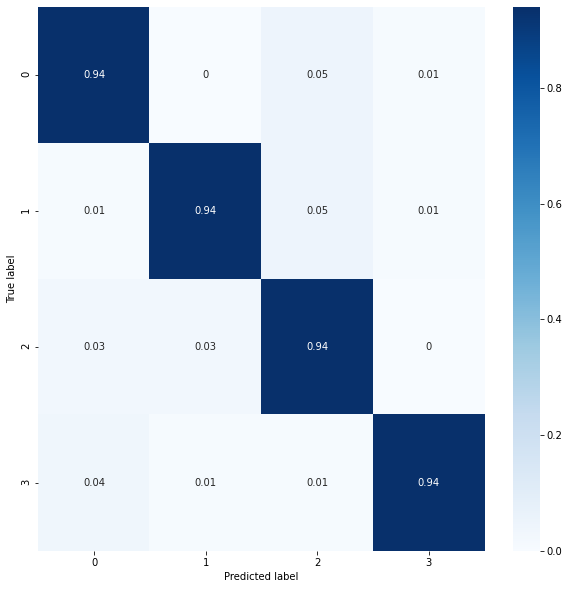

In [ ]:
main(train_model = False)